# Fruit Classification Using Transfer Learning

**Introduction**

In this lab, you will learn how to classify images of fruits using transfer learning with the pre-trained VGG16 model. Transfer learning enables leveraging a model trained on a large dataset (like ImageNet) and applying it to your dataset with fewer data and computational resources.

**Aim**

The aim is to build a fruit image classifier using transfer learning. You will fine-tune a pre-trained model on a custom dataset of fruit images to enable it to classify fruits effectively.

**Final output**

The final output will be a trained deep learning model capable of classifying various fruit images into their respective categories. You will also visualize the model's accuracy and predictions on sample test images.

**Tasks List**

To achieve the above objectives, you will complete the following tasks:

- Task 1: Import necessary libraries and set dataset paths
- Task 2: Set up data generators for training, validation, and testing with augmentation
- Task 3: Define the VGG16-based model architecture with custom layers
- Task 4: Compile the model with appropriate loss and optimizer
- Task 5: Train the model with early stopping and learning rate scheduling
- Task 6: Fine-tune the model by unfreezing specific layers in VGG16
- Task 7: Evaluate the model on the test set and display accuracy
- Task 8: Visualize training performance with accuracy and loss curves
- Task 9: Test model predictions on sample images and visualize results


In [36]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='keras.src.trainers.data_adapters.py_dateset_adapter')
warnings.filterwarnings('ignore', category=UserWarning, module='keras.src.trainers.epoch_iterator')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import subprocess
import zipfile

# Task 1: Import necessary libraries and set dataset paths
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import Counter
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img

train_dir = 'fruits-360-original-size/fruits-360-original-size/Training'
val_dir = 'fruits-360-original-size/fruits-360-original-size/Validation'
test_dir = 'fruits-360-original-size/fruits-360-original-size/Test'

In [ ]:
def download_dataset(url, output_file):
  """Download the dataset using curl."""
  print('Downloading the dataset...')
  subprocess.run(['curl', '-L', '-o', output_file, url], check=True)
  print('Download completed.')

def extract_zip_in_chunks(zip_file, extract_to, batch_size=2000):
  """
  Extract a large zip file in chunks to avoid memory bottlenecks.
  Processes a specified number of files (batch_size) at a time.
  """
  print('Extracting the dataset in chunks...')
  os.makedirs(extract_to, exist_ok=True)

  with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    files = zip_ref.namelist()
    total_files = len(files)

    for i in range(0, total_files, batch_size):
      batch = files[i:i+batch_size]
      for file in batch:
        zip_ref.extract(file, extract_to)
      print(f"Extracted {min(i+batch_size, total_files)} of {total_files} files...")

  print(f"Dataset successfully extracted to '{extract_to}'.")

In [14]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4yIRGlIpNfKEGJYMhZV52g/fruits-360-original-size.zip"
local_zip = "fruits-360-original-size.zip"
extract_dir = "fruits-360-original-size"

if __name__ == '__main__':
  if not os.path.exists(local_zip):
    download_dataset(url, local_zip)
  else:
    print('Dataset already downloaded.')

  if not os.path.exists(extract_dir):
    extract_zip_in_chunks(local_zip, extract_dir)
  else:
    print('Dataset already extracted.')

  if os.path.exists(local_zip):
    os.remove(local_zip)
    print(f"Cleaned up zip file: {local_zip}")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  552M  100  552M    0     0  25.3M      0  0:00:21  0:00:21 --:--:-- 25.6M


Download completed.
Extracting the dataset in chunks...
Extracted 2000 of 12481 files...
Extracted 4000 of 12481 files...
Extracted 6000 of 12481 files...
Extracted 8000 of 12481 files...
Extracted 10000 of 12481 files...
Extracted 12000 of 12481 files...
Extracted 12481 of 12481 files...
Dataset successfully extracted to 'fruits-360-original-size'.
Cleaned up zip file: fruits-360-original-size.zip


In [24]:
# Task 2: Set up data generators for training, validation, and testing with augmentation
train_datagen = ImageDataGenerator(
  rescale=1.0/255.0,
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True,
  fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
  train_dir,
  target_size=(64, 64),
  batch_size=16,
  class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
  val_dir,
  target_size=(64, 64),
  batch_size=16,
  class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
  test_dir,
  target_size=(64, 64),
  batch_size=16,
  class_mode='categorical'
)

Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.
Found 3110 images belonging to 24 classes.


**Explanation:** Data generators load images from directories, rescale them, and apply augmentation on the training set to help the model generalize better. Validation and test sets are only rescaled (no augmentation).

In [20]:
# Task 3:  Define the VGG16-based model architecture with custom layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

for layer in base_model.layers:
  layer.trainable = False

model = Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dense(256, activation='relu'),
  BatchNormalization(),
  Dropout(0.3),
  Dense(train_generator.num_classes, activation='softmax')
])

In [26]:
# Task 4: Compile the model with appropriate loss and optimizer
model.compile(
  optimizer='adam', 
  loss='categorical_crossentropy', 
  metrics=['accuracy']
)

In [27]:
# Task 5: Train the model with early stopping and learning rate scheduling
# Reduce learning rate when validation loss plateaus
lr_scheduler = ReduceLROnPlateau( 
                  monitor='val_loss', 
                  factor=0.2, 
                  patience=2, 
                  min_lr=1e-6, 
                  verbose=1
                )
early_stopping = EarlyStopping(
                  monitor='val_loss', 
                  patience=5, 
                  restore_best_weights=True
                )

set_global_policy('float32') # Enable mixed precision if on GPU

steps_per_epoch = 50
validation_steps = 25

history = model.fit(
  train_generator,
  epochs=5,
  validation_data=val_generator,
  steps_per_epoch=steps_per_epoch,
  validation_steps=validation_steps,
  callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 0.2566 - loss: 2.6060 - val_accuracy: 0.2150 - val_loss: 2.5861 - learning_rate: 0.0010
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.5025 - loss: 1.6320 - val_accuracy: 0.4275 - val_loss: 2.1190 - learning_rate: 0.0010
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.6313 - loss: 1.2160 - val_accuracy: 0.5150 - val_loss: 1.7290 - learning_rate: 0.0010
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.6687 - loss: 1.0505 - val_accuracy: 0.6400 - val_loss: 1.3978 - learning_rate: 0.0010
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - accuracy: 0.7088 - loss: 0.9043 - val_accuracy: 0.6175 - val_loss: 1.2281 - learning_rate: 0.0010


In [29]:
# Task 6: Fine-tune the model by unfreezing specific layers in VGG16
num_layers = len(base_model.layers)
print(f"The base model has {num_layers} layers.")

for layer in base_model.layers[-5:]:
  layer.trainable = True

for layer in base_model.layers:
  if isinstance(layer, tf.keras.layers.BatchNormalization):
    layer.trainable = False
  
# recompile model with a faster optimizer
model.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(learning_rate=1e-5),
  metrics=['accuracy']
)

history_fine = model.fit(
  train_generator,
  epochs=5,
  validation_data=val_generator,
  steps_per_epoch=steps_per_epoch,
  validation_steps=validation_steps,
  callbacks=[lr_scheduler, early_stopping]
)

The base model has 19 layers.
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step - accuracy: 0.7300 - loss: 0.8214 - val_accuracy: 0.6850 - val_loss: 0.9122 - learning_rate: 1.0000e-05
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step - accuracy: 0.8217 - loss: 0.6412 - val_accuracy: 0.8250 - val_loss: 0.6438 - learning_rate: 1.0000e-05
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.8250 - loss: 0.5680 - val_accuracy: 0.7875 - val_loss: 0.6005 - learning_rate: 1.0000e-05
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 202ms/step - accuracy: 0.8438 - loss: 0.5493 - val_accuracy: 0.8725 - val_loss: 0.4496 - learning_rate: 1.0000e-05
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 204ms/step - accuracy: 0.8388 - loss: 0.5225 - val_accuracy: 0.8350 - val_loss: 0.4946 - learning_rate: 1.0000e-05


In [30]:
# Task 7: Evaluate the model on the test set and display accuracy
test_loss, test_accuracy = model.evaluate(test_generator, steps=50)
print(f'Test Accuracy: {test_accuracy: .2f}')

/Users/victorcata/Documents/repos/ai-engineering-certificate/venv/lib/python3.13/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.8450 - loss: 0.4972
Test Accuracy:  0.85


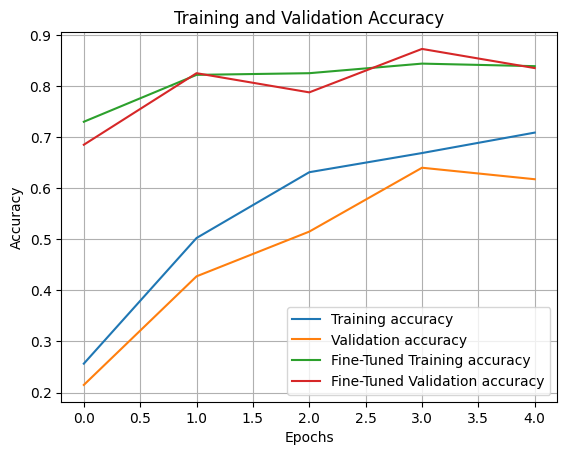

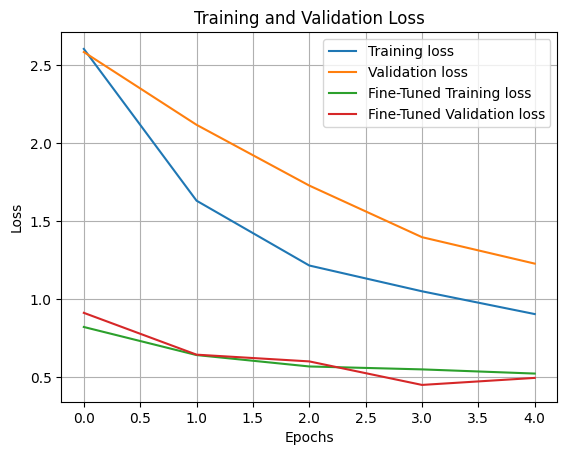

In [32]:
# Task 8: Visualize training performance with accuracy and loss curves
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-Tuned Training accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-Tuned Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)
plt.show()

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.plot(history_fine.history['loss'], label='Fine-Tuned Training loss')
plt.plot(history_fine.history['val_loss'], label='Fine-Tuned Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()

Class Index Mapping: {'apple_6': 0, 'apple_braeburn_1': 1, 'apple_crimson_snow_1': 2, 'apple_golden_1': 3, 'apple_golden_2': 4, 'apple_golden_3': 5, 'apple_granny_smith_1': 6, 'apple_hit_1': 7, 'apple_pink_lady_1': 8, 'apple_red_1': 9, 'apple_red_2': 10, 'apple_red_3': 11, 'apple_red_delicios_1': 12, 'apple_red_yellow_1': 13, 'apple_rotten_1': 14, 'cabbage_white_1': 15, 'carrot_1': 16, 'cucumber_1': 17, 'cucumber_3': 18, 'eggplant_violet_1': 19, 'pear_1': 20, 'pear_3': 21, 'zucchini_1': 22, 'zucchini_dark_1': 23}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


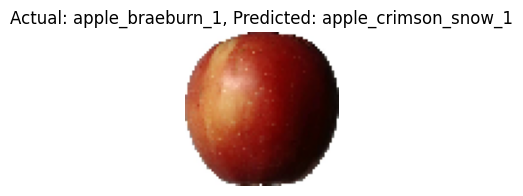

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


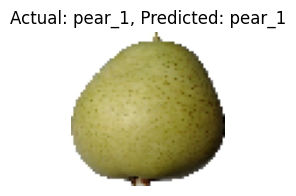

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


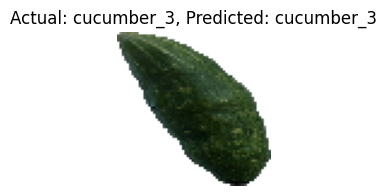

In [37]:
# Task 9: Test model predictions on sample images and visualize results
actual_count = Counter()
predicted_count = Counter()

def get_class_name_from_index(predicted_index, class_index_mapping):
  """Convert predicted index to class name."""
  for class_name, index in class_index_mapping.items():
    if index == predicted_index:
      return class_name
  return 'Unknown'

def visualize_prediction_with_actual(img_path, class_index_mapping):
  class_name = os.path.basename(os.path.dirname(img_path))

  img = load_img(img_path, target_size=(64, 64))
  img_array = img_to_array(img) / 255.0
  img_array = np.expand_dims(img_array, axis=0)

  prediction = model.predict(img_array)
  predicted_index = np.argmax(prediction, axis=-1)[0]
  predicted_class_name = get_class_name_from_index(predicted_index, class_index_mapping)

  actual_count[class_name] += 1
  predicted_count[predicted_class_name] += 1

  plt.figure(figsize=(2, 2), dpi=100)
  plt.imshow(img)
  plt.title(f'Actual: {class_name}, Predicted: {predicted_class_name}')
  plt.axis('off')
  plt.show()

class_index_mapping = train_generator.class_indices
print('Class Index Mapping:', class_index_mapping)

sample_images = [
  'fruits-360-original-size/fruits-360-original-size/Test/apple_braeburn_1/r0_11.jpg',
  'fruits-360-original-size/fruits-360-original-size/Test/pear_1/r0_103.jpg',
  'fruits-360-original-size/fruits-360-original-size/Test/cucumber_3/r0_103.jpg',
]

for img_path in sample_images:
  visualize_prediction_with_actual(img_path, class_index_mapping)


**If there is an incorrect prediction during testing, the following factors could contribute to the misclassification:**

- Class Similarity: Visually similar fruit classes (e.g., apple types) can confuse the model.

- Insufficient Data: Imbalanced datasets with fewer samples for certain classes may cause underfitting.

- Limited Training: Fine-tuning fewer layers might not capture sufficient class-specific features.

- Data Augmentation Impact: Aggressive augmentations may distort key features, reducing accuracy for specific images.